In [1]:
# %pip uninstall torch torchvision torchaudio transformers mamba-ssm tqdm pandas scikit-learn numpy -y
# %pip cache purge
# %pip install peft torch transformers mamba-ssm tqdm pandas scikit-learn numpy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [3]:
splice_df = pd.read_csv('../../splice_sites_full_centered_balanced_correct_V3.csv')
splice_df.head()

,id,coord,kind,transcript,strand,chrom,start,end,sequence,win_start,win_end,is_truncated,motif_len,motif
0,NC_050096.1_35318_donor,35318,0,XM_020544715.3,+,NC_050096.1,35319,35320,GGGCCCGGCTGGGCCTCAGCGGGGTCGTCGAGATGGAGATGGGGAG...,35118,35520,False,2,GT
1,NC_050096.1_34607_acceptor,34607,1,XM_020544715.3,+,NC_050096.1,34605,34606,TCCGGTGATTAATTTGTCCTTATACCTTTACAACAAAAATTCACTA...,34404,34806,False,2,TG
2,NC_050096.1_36174_donor,36174,0,XM_020544715.3,+,NC_050096.1,36175,36176,ATAATATGTTCATTATATCACAACACTCTTTTCTTATGGAGTCGTG...,35974,36376,False,2,GT
3,NC_050096.1_36037_acceptor,36037,1,XM_020544715.3,+,NC_050096.1,36035,36036,GCACAAAACTAACTAAAGGAATCATTCTGATAGATAACACTATAAA...,35834,36236,False,2,AG
4,NC_050096.1_36504_donor,36504,0,XM_020544715.3,+,NC_050096.1,36505,36506,TGTCATTTCCTTACCTCATTGAATCATTTCCGATGCTTCTTCTCTG...,36304,36706,False,2,GT


In [4]:
# Split data with stratification
train_df, temp_df = train_test_split(splice_df, test_size=0.3, stratify=splice_df['kind'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['kind'], random_state=42)

## Full Pipeline

In [5]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.4.0+cu121
CUDA available: True
CUDA version: 12.1


In [26]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoConfig
from mamba_ssm import Mamba
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
import numpy as np

In [27]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [28]:
# Cell 2: Dataset Class (Modified)
class DNASequenceDataset(Dataset):
    def __init__(self, sequences, labels, max_length=512):
        self.sequences = sequences
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.max_length = max_length
        self.nuc_to_idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4, 'P': 5}
        
        self.seq_encodings = []
        for seq in sequences:
            encoding = [self.nuc_to_idx.get(nuc, self.nuc_to_idx['N']) for nuc in seq[:max_length]]
            encoding += [self.nuc_to_idx['P']] * (max_length - len(encoding))
            self.seq_encodings.append(torch.tensor(encoding, dtype=torch.long))
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.seq_encodings[idx],
            'label': self.labels[idx]
        }

In [31]:
class MambaSequenceClassifier(nn.Module):
    def __init__(self, d_model=128, d_state=16, d_conv=4, expand=2, num_mamba_layers=4, n_classes=3, max_length=512):
        super().__init__()
        self.nuc_embedding = nn.Embedding(6, d_model)  # ACGTNP to d_model
        self.pos_embedding = nn.Embedding(max_length, d_model)  # Learnable positional embeddings

        nn.init.xavier_uniform_(self.nuc_embedding.weight)
        nn.init.xavier_uniform_(self.pos_embedding.weight)
        
        self.mamba = nn.Sequential(*[
            nn.Sequential(
                nn.LayerNorm(d_model),
                Mamba(
                    d_model=d_model,
                    d_state=d_state,
                    d_conv=d_conv,
                    expand=expand,
                    use_fast_path=True
                ),
                nn.Dropout(0.1),
            ) for _ in range(num_mamba_layers)
        ])

        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(0.1),
            nn.Linear(d_model, n_classes)
        )
        
        # # simple scalar attention over time
        # self.attention_pool = nn.Sequential(
        #     nn.Linear(d_model, 1),
        #     nn.Softmax(dim=1)
        # )

        # Mini attention MLP
        self.attention_pool = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.Tanh(),
            nn.Linear(d_model // 2, 1),
            nn.Softmax(dim=1)
        )
            
    def forward(self, sequence, labels=None):
        pos_ids = torch.arange(sequence.size(1), device=sequence.device).unsqueeze(0).expand(sequence.size(0), -1)
        x = self.nuc_embedding(sequence) + self.pos_embedding(pos_ids)  # Add position to nucleotide embeddings
        x = self.mamba(x)
        weights = self.attention_pool(x)  # [B, T, 1]
        x = (x * weights).sum(dim=1)
        logits = self.classifier(x)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss(label_smoothing=0.1)(logits, labels)
            return loss, logits
        return None, logits


In [32]:
# Cell 4: Model Initialization (Modified)
def prepare_model_and_data(train_df, val_df, test_df, sample_size=5000, max_length=512):
    train_sample = train_df.groupby('kind', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), sample_size // 3))
    ).reset_index(drop=True)

    val_sample = val_df.groupby('kind', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), sample_size // 15))
    ).reset_index(drop=True)

    test_sample = test_df.groupby('kind', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), sample_size // 15))
    ).reset_index(drop=True)
    
    train_dataset = DNASequenceDataset(
        sequences=train_sample['sequence'].tolist(),
        labels=train_sample['kind'].tolist(),
        max_length=max_length
    )

    val_dataset = DNASequenceDataset(
        sequences=val_sample['sequence'].tolist(),
        labels=val_sample['kind'].tolist(),
        max_length=max_length
    )
    
    test_dataset = DNASequenceDataset(
        sequences=test_sample['sequence'].tolist(),
        labels=test_sample['kind'].tolist(),
        max_length=max_length
    )
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32)
    test_dataloader = DataLoader(test_dataset, batch_size=32)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MambaSequenceClassifier(
        d_model=128,
        d_state=16,
        d_conv=4,
        expand=1,
        num_mamba_layers=4,
        n_classes=3
    ).to(device)
    
    return model, train_dataloader, val_dataloader, test_dataloader, device


In [33]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the model and return comprehensive metrics.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            sequence = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            loss, logits = model(sequence, labels)
            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    
    # Calculate F1 scores for each class
    f1_scores = f1_score(all_labels, all_preds, average=None)
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate precision and recall
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    
    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'f1_scores': f1_scores,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall
    }
    
    return metrics

In [35]:
def train_model(model, train_dataloader, val_dataloader, test_dataloader, device, 
                num_epochs=10, patience=3, learning_rate=1e-4,
                checkpoint_dir='checkpoints'):
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Initialize optimizer and tracking variables
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Initialize tracking lists with F1 scores
    history = {
        'epoch': [], 'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [], 'learning_rate': [],
        'train_f1_class0': [], 'train_f1_class1': [],
        'val_f1_class0': [], 'val_f1_class1': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []
        
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            sequence = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            loss, logits = model(sequence, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Calculate accuracy and store predictions
            predictions = torch.argmax(logits, dim=1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
            train_preds.extend(predictions.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = train_correct / train_total
        
        # Calculate F1 scores for training
        train_f1_scores = f1_score(train_labels, train_preds, average=None)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_dataloader:
                sequence = batch['sequence'].to(device)
                labels = batch['label'].to(device)
                
                loss, logits = model(sequence, labels)
                total_val_loss += loss.item()
                
                # Calculate accuracy and store predictions
                predictions = torch.argmax(logits, dim=1)
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
                val_preds.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = val_correct / val_total
        
        # Calculate F1 scores for validation
        val_f1_scores = f1_score(val_labels, val_preds, average=None)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history with F1 scores
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)
        history['learning_rate'].append(current_lr)
        history['train_f1_class0'].append(train_f1_scores[0])
        history['train_f1_class1'].append(train_f1_scores[1])
        history['val_f1_class0'].append(val_f1_scores[0])
        history['val_f1_class1'].append(val_f1_scores[1])
        
        # Print metrics
        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
        print(f'Train F1 (Class 0): {train_f1_scores[0]:.4f}, Train F1 (Class 1): {train_f1_scores[1]:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        print(f'Val F1 (Class 0): {val_f1_scores[0]:.4f}, Val F1 (Class 1): {val_f1_scores[1]:.4f}')
        print(f'Learning Rate: {current_lr}')
        
        # Save checkpoint for this epoch
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_acc': train_accuracy,
            'val_acc': val_accuracy,
            'train_f1_class0': train_f1_scores[0],
            'train_f1_class1': train_f1_scores[1],
            'val_f1_class0': val_f1_scores[0],
            'val_f1_class1': val_f1_scores[1],
            'learning_rate': current_lr
        }
        torch.save(checkpoint, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pt'))
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            
            # Save best model
            best_checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_acc': train_accuracy,
                'val_acc': val_accuracy,
                'train_f1_class0': train_f1_scores[0],
                'train_f1_class1': train_f1_scores[1],
                'val_f1_class0': val_f1_scores[0],
                'val_f1_class1': val_f1_scores[1],
                'learning_rate': current_lr
            }
            torch.save(best_checkpoint, os.path.join(checkpoint_dir, 'best_model.pt'))
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch + 1}')
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Final evaluation on test set
    print("\nPerforming final evaluation on test set...")
    test_metrics = evaluate_model(model, test_dataloader, device)
    
    print("\n=== Final Test Evaluation ===")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (Class 0): {test_metrics['f1_scores'][0]:.4f}")
    print(f"Test F1 (Class 1): {test_metrics['f1_scores'][1]:.4f}")
    print("\nConfusion Matrix:")
    print(test_metrics['confusion_matrix'])
    print("\nPrecision (Class 0, Class 1):", test_metrics['precision'])
    print("Recall (Class 0, Class 1):", test_metrics['recall'])
    
    # Save final model with test metrics
    final_checkpoint = {
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'train_acc': train_accuracy,
        'val_acc': val_accuracy,
        'train_f1_class0': train_f1_scores[0],
        'train_f1_class1': train_f1_scores[1],
        'val_f1_class0': val_f1_scores[0],
        'val_f1_class1': val_f1_scores[1],
        'learning_rate': current_lr,
        'test_metrics': test_metrics
    }
    torch.save(final_checkpoint, os.path.join(checkpoint_dir, 'final_model.pt'))
    
    # Convert history to DataFrame
    history_df = pd.DataFrame(history)
    return history_df, test_metrics

In [ ]:
# Cell 6: Run the Pipeline
# Initialize model and data
model, train_dataloader, val_dataloader, test_dataloader, device = prepare_model_and_data(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    sample_size=200000
)

# Train the model
history_df, test_metrics = train_model(
    model, 
    train_dataloader, 
    val_dataloader, 
    test_dataloader, 
    device, 
    num_epochs=20, 
    patience=3, 
    learning_rate=1e-4,
    checkpoint_dir='model_checkpoints'
)

/tmp/ipykernel_2025886/1735246176.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_sample = train_df.groupby('kind', group_keys=False).apply(
/tmp/ipykernel_2025886/1735246176.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_sample = val_df.groupby('kind', group_keys=False).apply(
/tmp/ipykernel_2025886/1735246176.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping col

Epoch 1/20:   0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 1/20:
Train Loss: 0.5330, Train Acc: 0.8641
Train F1 (Class 0): 0.8814, Train F1 (Class 1): 0.8704
Val Loss: 0.4437, Val Acc: 0.9224
Val F1 (Class 0): 0.9347, Val F1 (Class 1): 0.9321
Learning Rate: 0.0001


Epoch 2/20:   0%|          | 0/6250 [00:00<?, ?it/s]

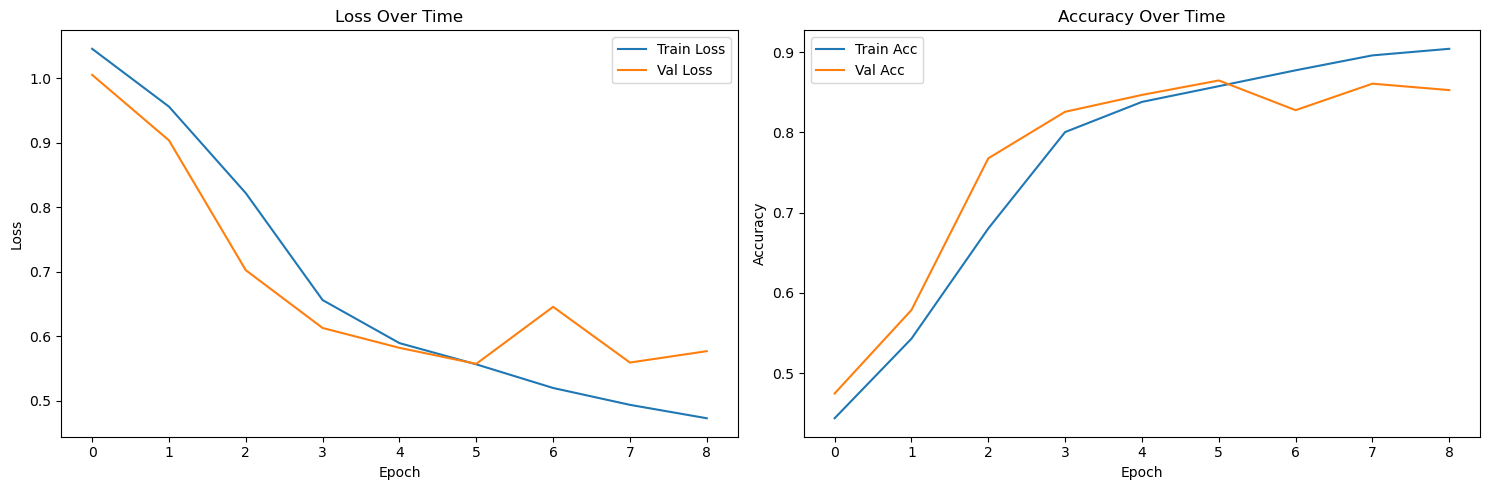

In [38]:
# Plot training history
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['train_loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.subplot(1, 2, 2)
plt.plot(history_df['train_acc'], label='Train Acc')
plt.plot(history_df['val_acc'], label='Val Acc')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [39]:
def load_best_model_and_evaluate(model, checkpoint_path, test_dataloader, device):
    """
    Load the best model checkpoint and evaluate it on the test set.
    
    Args:
        model: The model architecture
        checkpoint_path: Path to the best model checkpoint
        test_dataloader: DataLoader for the test set
        device: Device to run the model on (cuda or cpu)
    
    Returns:
        test_metrics: Dictionary containing test metrics
    """
    # Load the checkpoint
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    # Print checkpoint information
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"Validation loss: {checkpoint['val_loss']:.4f}")
    print(f"Validation accuracy: {checkpoint['val_acc']:.4f}")
    print(f"Validation F1 (Class 0): {checkpoint['val_f1_class0']:.4f}")
    print(f"Validation F1 (Class 1): {checkpoint['val_f1_class1']:.4f}")
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_metrics = evaluate_model(model, test_dataloader, device)
    
    # Print test metrics
    print("\n=== Test Evaluation Results ===")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (Class 0): {test_metrics['f1_scores'][0]:.4f}")
    print(f"Test F1 (Class 1): {test_metrics['f1_scores'][1]:.4f}")
    print("\nConfusion Matrix:")
    print(test_metrics['confusion_matrix'])
    print("\nPrecision (Class 0, Class 1):", test_metrics['precision'])
    print("Recall (Class 0, Class 1):", test_metrics['recall'])
    
    return test_metrics

# Example usage:
# checkpoint_path = 'model_checkpoints/best_model.pt'
# test_metrics = load_best_model_and_evaluate(model, checkpoint_path, test_dataloader, device)

In [40]:
# After training, load the best model and evaluate
checkpoint_path = 'model_checkpoints/best_model.pt'
test_metrics = load_best_model_and_evaluate(model, checkpoint_path, test_dataloader, device)

Loading checkpoint from model_checkpoints/best_model.pt...
Loaded checkpoint from epoch 6
Validation loss: 0.5573
Validation accuracy: 0.8649
Validation F1 (Class 0): 0.8955
Validation F1 (Class 1): 0.8708

Evaluating on test set...

=== Test Evaluation Results ===
Test Loss: 0.5844
Test Accuracy: 0.8549
Test F1 (Class 0): 0.8674
Test F1 (Class 1): 0.8750

Confusion Matrix:
[[278  21  34]
 [  3 294  36]
 [ 27  24 282]]

Precision (Class 0, Class 1): [0.9025974  0.86725664 0.80113636]
Recall (Class 0, Class 1): [0.83483483 0.88288288 0.84684685]


/tmp/ipykernel_2025886/194904196.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


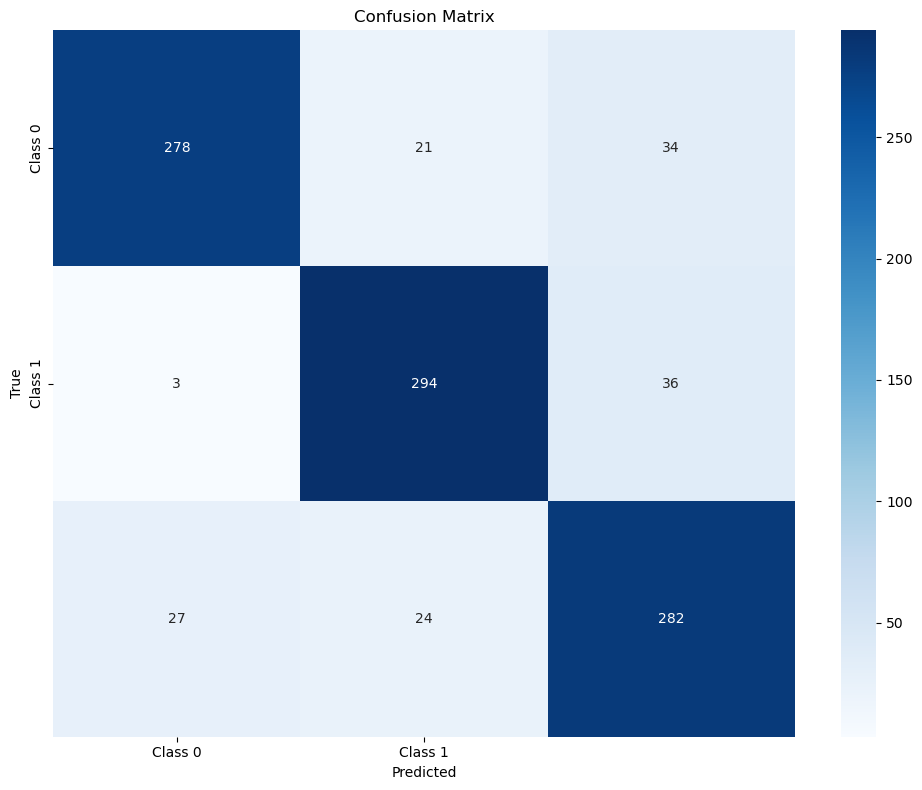

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, class_names=None):
    """
    Plot confusion matrix as a heatmap.
    
    Args:
        confusion_matrix: 2D numpy array of confusion matrix
        class_names: List of class names (optional)
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(test_metrics['confusion_matrix'], 
                     class_names=['Class 0', 'Class 1'])